## 1） Read Data

In [1]:
# ! git clone https://huggingface.co/datasets/YuAnthony/tnews

In [2]:
# !pip install matplotlib

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import RobertaModel

# from transformers import BertPreTrainedModel, BertConfig, BertModel

In [5]:
class config():
    train_data_path = './tnews/train.json'
    dev_data_path = './tnews/dev.json'
    test_data_path = './tnews/test.json'
    label_data_path = './tnews/labels.json'
    bert_name = "hfl/chinese-roberta-wwm-ext"
    max_length  = 60
    batch_size = 8
    epochs = 20
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    do_acc = False
    do_recall = False
    do_precision = False
    do_f1 = False
    print_report = False

In [6]:
def get_raw_data(config,data_type='train',nums_sample = -1):
    text = []
    label = []
    data_path = {"train":config.train_data_path,
                "dev":config.dev_data_path,
                "test":config.test_data_path}[data_type]
    with open(data_path, encoding='utf-8')as file:
        for line in file.readlines()[:nums_sample]:
            line = line.strip()
            dic = json.loads(line)
            text.append(dic['sentence'])
            label.append(dic['label'])
    
    df = pd.DataFrame()
    df['text'] = text
    df['label'] = label
    return df

In [7]:
def get_labels_dict(config):
    label_dict = {}
    with open(config.label_data_path, encoding='utf-8')as file:
        for line in file.readlines():
            line = line.strip()
            dic = json.loads(line)
            label_dict[dic['label']]=dic['label_desc']
    return label_dict

In [8]:
df_train = get_raw_data(config,"train",512)
df_dev = get_raw_data(config,"dev",100)
labels_dict = get_labels_dict(config)

In [9]:
df_train.head()

,text,label
0,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？,108
1,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告,104
2,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？,106
3,2018年去俄罗斯看世界杯得花多少钱？,112
4,剃须刀的个性革新，雷明登天猫定制版新品首发,109


In [10]:
labels_dict

{'100': 'news_story',
 '101': 'news_culture',
 '102': 'news_entertainment',
 '103': 'news_sports',
 '104': 'news_finance',
 '106': 'news_house',
 '107': 'news_car',
 '108': 'news_edu',
 '109': 'news_tech',
 '110': 'news_military',
 '112': 'news_travel',
 '113': 'news_world',
 '114': 'news_stock',
 '115': 'news_agriculture',
 '116': 'news_game'}

## 2) Process Data According to Prompt Template

In [11]:
tokenizer = AutoTokenizer.from_pretrained(config.bert_name)

In [12]:
label_dic = {'100': '民生', '101': '文化', '102': '娱乐', '103': '体育', '104': '财经', '106': '房产', '107': '汽车',
                          '108': '教育', '109': '科技', '110': '军事', '112': '旅游', '113': '国际', '114': '证券', '115': '农业',
                          '116': '游戏'}

In [13]:
label_index = {k: i for i, (k, v) in enumerate(label_dic.items())}

In [14]:
label_idx_dic = {k: tokenizer.convert_tokens_to_ids(list(v)) for k, v in label_dic.items()}

In [15]:
label_idx_dic #these tokens to fill prompt tempalte

{'100': [3696, 4495],
 '101': [3152, 1265],
 '102': [2031, 727],
 '103': [860, 5509],
 '104': [6568, 5307],
 '106': [2791, 772],
 '107': [3749, 6756],
 '108': [3136, 5509],
 '109': [4906, 2825],
 '110': [1092, 752],
 '112': [3180, 3952],
 '113': [1744, 7354],
 '114': [6395, 1171],
 '115': [1093, 689],
 '116': [3952, 2767]}

In [16]:
def get_token_length(text):
    encoding = tokenizer(text)
    return len(encoding['input_ids'])

In [17]:
df_train.head()

,text,label
0,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？,108
1,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告,104
2,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？,106
3,2018年去俄罗斯看世界杯得花多少钱？,112
4,剃须刀的个性革新，雷明登天猫定制版新品首发,109


In [18]:
token_len_list = df_train['text'].apply(lambda x:get_token_length(x))

(array([ 23.,  47.,  96.,  86.,  98., 101.,  46.,   8.,   2.,   5.]),
 array([ 7. , 11.1, 15.2, 19.3, 23.4, 27.5, 31.6, 35.7, 39.8, 43.9, 48. ]),
 <BarContainer object of 10 artists>)

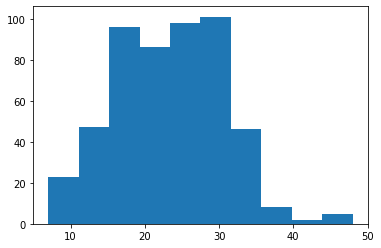

In [19]:
plt.hist(token_len_list)

In [20]:
def get_token_ids(text):
    encoding = tokenizer(text = text,
                         max_length = config.max_length,
                         padding="max_length",
                         truncation=True,
                         return_tensors = "pt",)
    return encoding

In [21]:
tokenizer.mask_token

'[MASK]'

In [22]:
def inputs_process(data_text, data_label):

    prompt_template = '播报一则[MASK][MASK]新闻：'
    mask_pos = [5, 6]

    encodings = []
    labels = []
    for text, label in zip(data_text, data_label):
        text = prompt_template + text # templata
        encoding = get_token_ids(text)
        encodings.append(encoding) 
        labels.append(label_index[label])

    item = {}
    for encoding in encodings:
        for key in ['input_ids', 'attention_mask']:
            if key in item.keys():
                item[key].append(encoding[key])
            else:
                item[key] = [encoding[key]]

    for key in ['input_ids', 'attention_mask']:
        item[key] = torch.cat(item[key])
        
    return item, labels

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [24]:
def get_data_loader(df):
    text  = df['text']
    label  = df['label']
    
    encoding, label = inputs_process(text, label)
    
    return DataLoader(Dataset(encoding, label), config.batch_size)

In [25]:
train_loader = get_data_loader(df_train)

In [26]:
dev_loader = get_data_loader(df_dev)

In [27]:
for sample in train_loader:
    break

In [28]:
sample['input_ids'].shape

torch.Size([8, 60])

In [29]:
sample.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [30]:
"""Test"""

'Test'

In [31]:
label_idx = label_idx_dic.values()

In [32]:
label_idx_0, label_idx_1 = zip(*label_idx)

## 3) Prompt Tuning

In [33]:
"""Debug"""

'Debug'

In [34]:
for data in train_loader:
    break

In [35]:
input_ids = data['input_ids'].to(config.device)
attention_mask = data['attention_mask'].to(config.device)

In [36]:
attention_mask.shape

torch.Size([8, 60])

### 3.1 Model Construction

In [37]:
# transformers.models.bert.modeling_bert.BertModel
from transformers import RobertaConfig, RobertaModel

In [38]:
from transformers.models.bert.modeling_bert import BertOnlyMLMHead

In [39]:
configuration = RobertaConfig()
bert = RobertaModel(configuration,add_pooling_layer=False).to(config.device)

In [40]:
cls_layer = BertOnlyMLMHead(configuration)  # MLM vocab multi-classification

In [41]:
input_ids = data['input_ids'].to(config.device)
attention_mask = data['attention_mask'].to(config.device)

In [44]:
bert = bert.to(config.device)
cls_layer = cls_layer.to(config.device)

In [45]:
with torch.no_grad():
    outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
    logits = cls_layer(outputs[0])

In [48]:
token_logits = logits

In [72]:
token_logits.shape

torch.Size([8, 60, 30522])

In [77]:
token_logits_1 =  token_logits[:,mask_pos[0],:] # take the mask position [batch_size,vocab_size]

In [84]:
token_logits_2 = token_logits_1[:, label_idx_0] # [batch_size,score of corresponding values]

In [85]:
token_logits_2.shape

torch.Size([8, 15])

In [86]:
mask_logits = token_logits[:, mask_pos[0]][:, label_idx_0] + \
            token_logits[:,mask_pos[1]][:, label_idx_1]

In [87]:
mask_logits.shape

torch.Size([8, 15])

In [49]:
mask_pos = [5, 6]

In [58]:
token_logits[:, mask_pos[0]][:,[0:1]]

tensor([[-0.0649,  0.8618,  0.5800,  ..., -0.1845, -0.1193,  0.8773],
        [-0.7712,  0.4287,  0.0941,  ..., -0.1884,  0.5348,  0.2472],
        [-0.1336,  0.5467,  0.8326,  ...,  0.1663,  0.4030,  0.3776],
        ...,
        [-0.1685,  0.6121,  0.2482,  ..., -0.4368,  0.1812, -0.1295],
        [-0.3379,  0.3610,  0.2945,  ...,  0.0212,  0.6105, -0.1500],
        [-0.5605,  0.5784, -0.0747,  ...,  0.4578,  0.5981,  0.2168]],
       device='cuda:0')

In [64]:
token_logits[:, mask_pos[0]][:,0].shape

tensor([-0.0649, -0.7712, -0.1336, -0.6649, -0.4029, -0.1685, -0.3379, -0.5605],
       device='cuda:0')

In [71]:
token_logits[:, mask_pos[0]][:,[0,1]]

tensor([[-0.0649,  0.8618],
        [-0.7712,  0.4287],
        [-0.1336,  0.5467],
        [-0.6649,  0.6610],
        [-0.4029,  0.4836],
        [-0.1685,  0.6121],
        [-0.3379,  0.3610],
        [-0.5605,  0.5784]], device='cuda:0')

In [53]:
[:, label_idx_0]

SyntaxError: invalid syntax (1047493638.py, line 1)

In [50]:
mask_logits = token_logits[:, mask_pos[0]][:, label_idx_0] + \
    token_logits[:, mask_pos[1]][:, label_idx_1]

In [94]:
outputs.keys()

odict_keys(['last_hidden_state'])

In [96]:
outputs.last_hidden_state.shape

torch.Size([8, 60, 768])

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 4.1580e-01, -9.1603e-01,  8.6591e-02,  ...,  1.1301e-01,
           5.7214e-01,  9.4964e-01],
         [ 1.2901e+00, -6.8629e-01, -3.2986e-01,  ...,  5.2748e-01,
           2.4873e-01,  4.3296e-01],
         [-1.1646e+00, -8.0976e-01, -5.6755e-01,  ..., -2.5062e-01,
          -1.3998e+00,  7.0954e-01],
         ...,
         [-3.1455e-01, -3.4643e-02,  5.7883e-01,  ...,  1.3990e+00,
          -8.5608e-01,  1.1558e-01],
         [-1.1999e+00,  4.5291e-01, -6.8696e-01,  ...,  5.4611e-01,
           2.8636e-01,  9.4848e-02],
         [-1.2895e+00,  3.3704e-01, -1.7707e+00,  ...,  1.2694e+00,
          -5.2734e-01,  6.4019e-01]],

        [[-4.1272e-01, -1.5621e+00,  2.1502e-01,  ...,  2.1669e+00,
           2.3557e-02,  6.8620e-01],
         [ 6.4791e-01, -7.9876e-01,  2.1138e-01,  ...,  7.3984e-01,
           7.4993e-01,  8.2055e-01],
         [-1.6781e+00, -9.3270e-01, -7.6341e-01,  ...,  1.7413e-01,
          -6.

In [43]:
from transformers import BertPreTrainedModel

In [45]:
class BertForPromptTuning(BertPreTrainedModel):
    def __init__(self, config: BertConfig, prompt_index):
        super().__init__(config)
        self.num_labels = config.num_labels
        
        self.bert = RobertaModel(config, add_pooling_layer=False)  # backbone
        self.cls = BertOnlyMLMHead(config)  # MLM vocab multi-classification
        self.init_weights()
    
    def set_output_embeddings(self, new_embeddings):
        """Use word embedding weight as the output weight in the cls layer"""
        self.cls.predictions.decoder.weight = new_embeddings.weight
        
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None):
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        
        
        self.set_output_embeddings(self.bert.embeddings.word_embeddings)

            outputs = self.bert(
            input_ids=None,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict)

        # outputs[0] -> shape [batch_size,max_length,hidden_size (768)]
        logits = self.cls(outputs[0])
        
        # logits:  -> shape [batch_size,max_length,vocab_size]
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            s = attention_mask.shape[0] * attention_mask.shape[1]
            loss = loss_fct(logits.view(s, -1), labels.view(-1))

        # logits: tokens out-> [batch_size,max_length,vocab_size]
        # pool out: outputs[1:] -> [batch_size,max_length,hidden_size]
        # cls : outputs[0][:, 0] -> first token cls output [batch_size,hidden_size]
        output = (logits,) + outputs[1:] + (outputs[0][:, 0],)
        return ((loss,) + output) if loss is not None else output

IndentationError: unexpected indent (3183954656.py, line 32)

In [77]:
with torch.no_grad():
    outputs = model(input_ids = input_ids,attention_mask = attention_mask,)

In [83]:
outputs.keys()

odict_keys(['last_hidden_state'])

In [80]:
# outputs[1].shape

In [84]:
label_idx_dic

{'100': [3696, 4495],
 '101': [3152, 1265],
 '102': [2031, 727],
 '103': [860, 5509],
 '104': [6568, 5307],
 '106': [2791, 772],
 '107': [3749, 6756],
 '108': [3136, 5509],
 '109': [4906, 2825],
 '110': [1092, 752],
 '112': [3180, 3952],
 '113': [1744, 7354],
 '114': [6395, 1171],
 '115': [1093, 689],
 '116': [3952, 2767]}

In [85]:
label_idx_0, label_idx_1 = zip(*label_idx)

In [87]:
label_idx_1

(4495,
 1265,
 727,
 5509,
 5307,
 772,
 6756,
 5509,
 2825,
 752,
 3952,
 7354,
 1171,
 689,
 2767)

In [86]:
label_idx_0

(3696,
 3152,
 2031,
 860,
 6568,
 2791,
 3749,
 3136,
 4906,
 1092,
 3180,
 1744,
 6395,
 1093,
 3952)